# Train Steering Model



In [1]:
"""
Steering angle prediction model
"""
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from keras.models import Sequential
from keras.utils.visualize_util import plot as keras_plot
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Cropping2D
from keras.layers.convolutional import Convolution2D
from scipy.stats import bernoulli
from scipy.misc import imresize
from sklearn.utils import shuffle


from sklearn.model_selection import train_test_split

STEER_OFFSET = 0.22
CROPPING_TOP=60
CROPPING_BOTTOM=20

Using TensorFlow backend.


In [2]:
def get_model():
    row, col, ch = 64, 64, 3  # camera format
    model = Sequential()
    model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(row, col, ch), output_shape=(row, col, ch)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    model.summary()
    return model


In [3]:
def remove_low_throttle_data(df):
    ind = df['throttle']>.25
    return df[ind].reset_index(drop=True)

def remove_low_steering_data(df):
    ind = df['steering']>0.10
    return df[ind].reset_index(drop=True)

def plot_steering_data(df, length):
    steer_s = np.array(df['steering'],dtype=np.float32)
    t_s = np.arange(len(steer_s))
    x_s = np.array(df['steering'])

    plt.plot(t_s[:length],x_s[:length]);
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.ylim(-1,1);
    plt.show()

In [4]:
def random_gamma(image):
    '''
    Random gamma correction is used as an alternative method changing the brightness of
    training images.
    http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
    '''
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def crop(img, top=CROPPING_TOP, bottom=CROPPING_BOTTOM):
    return img[top:img.shape[0]-bottom]

def random_flip(img, steer_angle, prob=0.5):
    if bernoulli.rvs(prob) == 1:
        return np.fliplr(img), -1 * steer_angle
    else:
        return img, steer_angle

def random_rotation(img, steering_angle, rotation_amount=15):
    angle = np.random.uniform(-rotation_amount, rotation_amount + 1)
    rad = (np.pi / 180.0) * angle
    return rotate(img, angle, reshape=False), steering_angle + (-1) * rad

def random_shear(img, steer_angle, shear_range=200):
    """
    Source: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk
    """
    rows, cols, ch = img.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    img = cv2.warpAffine(img, M, (cols, rows), borderMode=1)
    steer_angle += dsteering
    return img, steer_angle

def generate_new_image(img, steer_angle, resize_dim=(64, 64), shear_prob=0.2, save_image=0, fname=""): 
    if bernoulli.rvs(shear_prob) == 1:
        img, steer_angle = random_shear(img, steer_angle)
        if save_image:
            plt.imsave("data/output_images/sheared_{}".format(fname.split("/")[-1]), img)       
    img = crop(img)
    if save_image:
            plt.imsave("data/output_images/cropped_{}".format(fname.split("/")[-1]), img)
    img, steer_angle = random_flip(img, steer_angle)
    if save_image:
            plt.imsave("data/output_images/random_flip_{}".format(fname.split("/")[-1]), img)
    img = random_gamma(img)
    if save_image:
            plt.imsave("data/output_images/random_gamma_{}".format(fname.split("/")[-1]), img)
    img = imresize(img, resize_dim)
    if save_image:
            plt.imsave("data/output_images/resized64x64_{}".format(fname.split("/")[-1]), img)
    return img, steer_angle

def verify_image_generation_pipeline(df):
        df = df.sample(frac=1).reset_index(drop=True)
        for i in range(10):
            generate_new_image_from_random_camera(df, i, save_image=1)
            

    

def generate_new_image_from_random_camera(df, idx, save_image=0):
    camera={0:"left", 1:"center", 2:"right"}
    steer_offset={0:-STEER_OFFSET, 1:0, 2:STEER_OFFSET}
    rnd_cmra = np.random.randint(0, 3)
    img = plt.imread("data/original/IMG/{}".format(df[camera[rnd_cmra]][idx].split("/")[-1]))
    steer_angle = df["steering"][idx] + steer_offset[rnd_cmra]
    img, steer_angle = generate_new_image(img, steer_angle, save_image=save_image, fname=df[camera[rnd_cmra]][idx])
    return img, steer_angle
    
def generate_training_data_from_df(df, batch_size=128):
    df = df.sample(frac=1).reset_index(drop=True)
    k=0
    while 1:
        if(k*batch_size >= len(df)):
            k=0
        batch_X = np.empty([0, 64, 64, 3])
        batch_y = np.empty([0], "float32")
        for i in range(batch_size):
            img, steer_angle = generate_new_image_from_random_camera(df, i)
            batch_X = np.append(batch_X, [img], axis=0) 
            batch_y = np.append(batch_y, [steer_angle], axis=0)
        k=k+1
        yield batch_X, batch_y

def generate_validation_data_from_df(df):
    df = df.sample(frac=1).reset_index(drop=True)
    while 1:
        for k in range(len(df)): 
            img, steer_angle = generate_new_image_from_random_camera(df, k)
            X = np.array([img]) 
            y = np.array([steer_angle])
            yield X, y

In [5]:
def plot_loss(history_object):
    print(history_object.history.keys())
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 16, 16, 16)    3088        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 16, 16, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 8, 8, 32)      12832       elu_1[0][0]                      
___________________________________________________________________________________________

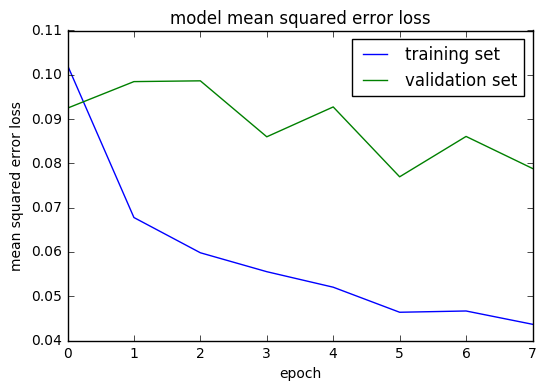

Saving model weights and configuration file.


In [6]:
if __name__ == "__main__":
    
    model = get_model()
    keras_plot(model, to_file='model.png')
    
    dtfrm=pd.read_csv("data/original/driving_log.csv")
    
    print("Number of available samples: {}".format(len(dtfrm)))
    dtfrm = remove_low_throttle_data(dtfrm)
    #dtfrm = remove_low_steering_data(dtfrm)

    dtfrm = shuffle(dtfrm)

    print("Number of available samples after removing low throttle values: {}".format(len(dtfrm)))

    dfT, dfV = train_test_split(dtfrm, test_size=0.3)

    print("Number of Training samples: {}".format(len(dfT)))
    print("Number of Validation samples: {}".format(len(dfV)))

    BATCH_SIZE = 256

    train_gen = generate_training_data_from_df(dfT, batch_size=BATCH_SIZE)
    valid_gen = generate_validation_data_from_df(dfV)
    
    verify_image_generation_pipeline(dfT)
    
    history = model.fit_generator(train_gen, samples_per_epoch=BATCH_SIZE*100, validation_data=valid_gen, nb_epoch=8, nb_val_samples=BATCH_SIZE*8, verbose=1)

    plot_loss(history)

    print("Saving model weights and configuration file.")

    model.save("model.h5")   
    model.save_weights("model.keras", True)
    with open('model.json', 'w') as outfile:
      json.dump(model.to_json(), outfile)
    import gc; gc.collect()
